In [1]:
sc

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
9,application_1675623994201_0010,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-9>

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import numpy as np
from scipy.stats import multivariate_normal

np.random.seed(0)

import pandas as pd

from pyspark.mllib.linalg.distributed import IndexedRowMatrix, IndexedRow

from pyspark.sql.functions import udf, struct
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
import pyspark.sql.functions as f


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Create a dataset

In [4]:
K=3 # number of sources
d=2 # dimension of the data
    
def create_dataset():
    # Create dataset
    
    X=[]
    mu1=[2,2]
    Sigma1=np.array([[3,-2],[-2,3]])
    Gauss1= multivariate_normal(mean=mu1,cov=Sigma1)
    samples1=Gauss1.rvs(200) # Draw random samples from the multivariate normal distribution.

    mu2=[-8,-4]
    Sigma2=np.array([[4,2],[2,4]])
    Gauss2= multivariate_normal(mean=mu2,cov=Sigma2)
    samples2=Gauss2.rvs(400)

    mu3=[-8,7]
    Sigma3=np.array([[1,0],[0,1]])
    Gauss3= multivariate_normal(mean=mu3,cov=Sigma3)
    samples3=Gauss3.rvs(600)

    X=np.vstack((samples1,samples2,samples3))
    
    np.random.shuffle(X)
    return X


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
X=create_dataset()
n_samples = len(X)
print(X.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1200, 2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

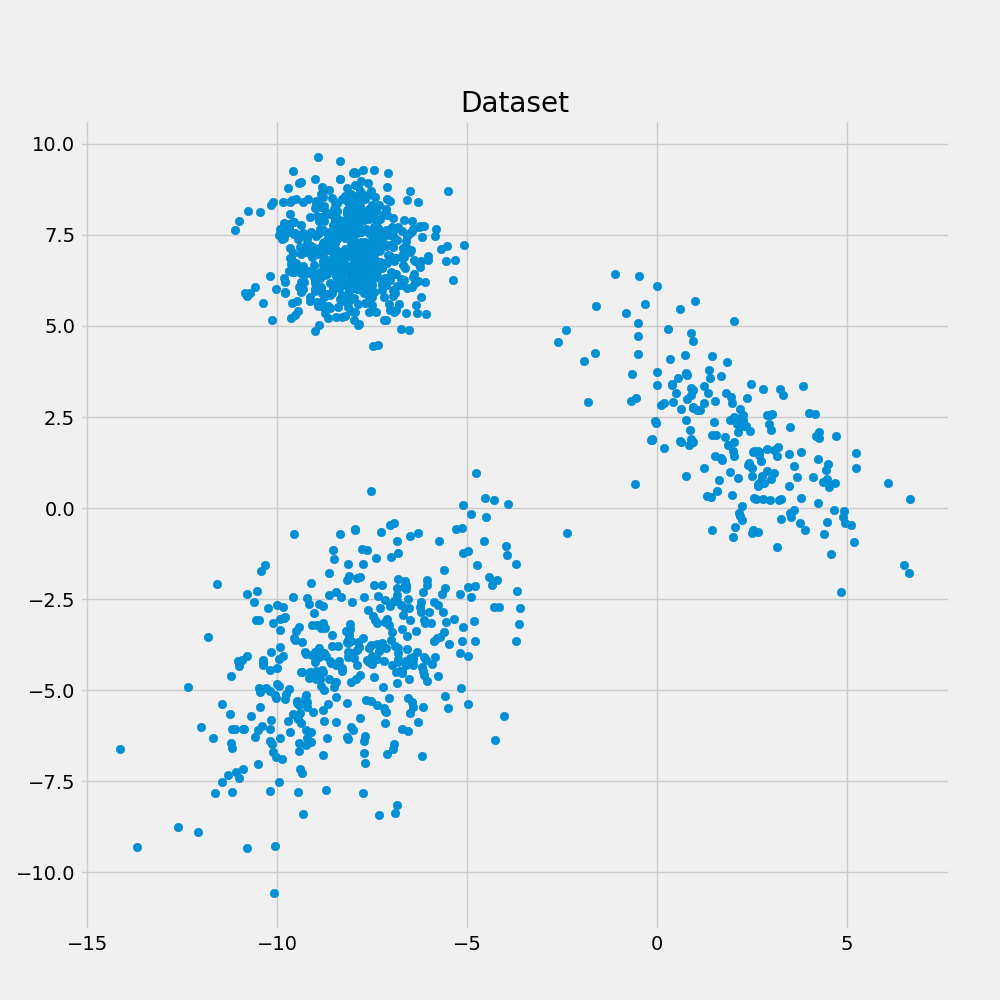

In [6]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.set_title('Dataset')

%matplot plt

### Initalize Parameters

In [7]:
 
def init_params(K,d):
    """ Set the initial mu, covariance and pi values"""

    # This is a Kxd matrix since we assume K Gaussians where each has d dimensions
    mu=np.array([[1.0,0.0],[-5.0,2.0],[-2.0,-2.0]])
    #mu = np.random.randint(-4,4,size=(K,d)) 

    print(mu)

    
    # We need a Kxdxd covariance matrix for each Gauss distribution since we have d features 
    #--> We create symmetric covariance matrices with ones on the digonal
    
    cov = np.zeros((K,d,d))
    print(cov.shape)

    for dim in range(len(cov)):
        np.fill_diagonal(cov[dim],2.0)

    print(cov)

    # Set pi to uniform distribution
    pi = np.ones(K)/K 
    print(pi)

    return mu, cov, pi



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
mu, cov, pi = init_params(K,d)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]

In [9]:
def plot_results(X, **kwargs):
    """Plot the dataset"""    
    
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(X[:,0],X[:,1])
    
    try:
      title = kwargs['title']
    except:
      title='results'
    ax0.set_title(title)
    
    try:
        mu = kwargs['mu']
        for m in mu:
            ax0.scatter(m[0],m[1],c='red',zorder=10,s=100)
    except:
        pass
    
    try:
        cov = kwargs ['cov']
        x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
        XY = np.array([x.flatten(),y.flatten()]).T
        reg_cov = 1e-6*np.identity(len(X[0,:]))
        
        for c,m in zip(cov,mu):
            c += reg_cov
            # let us set up the mean and covariance of a multi-dim gaussian
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    
    except:
        pass
    
    plt.show()
    fig.savefig(title+'.png')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

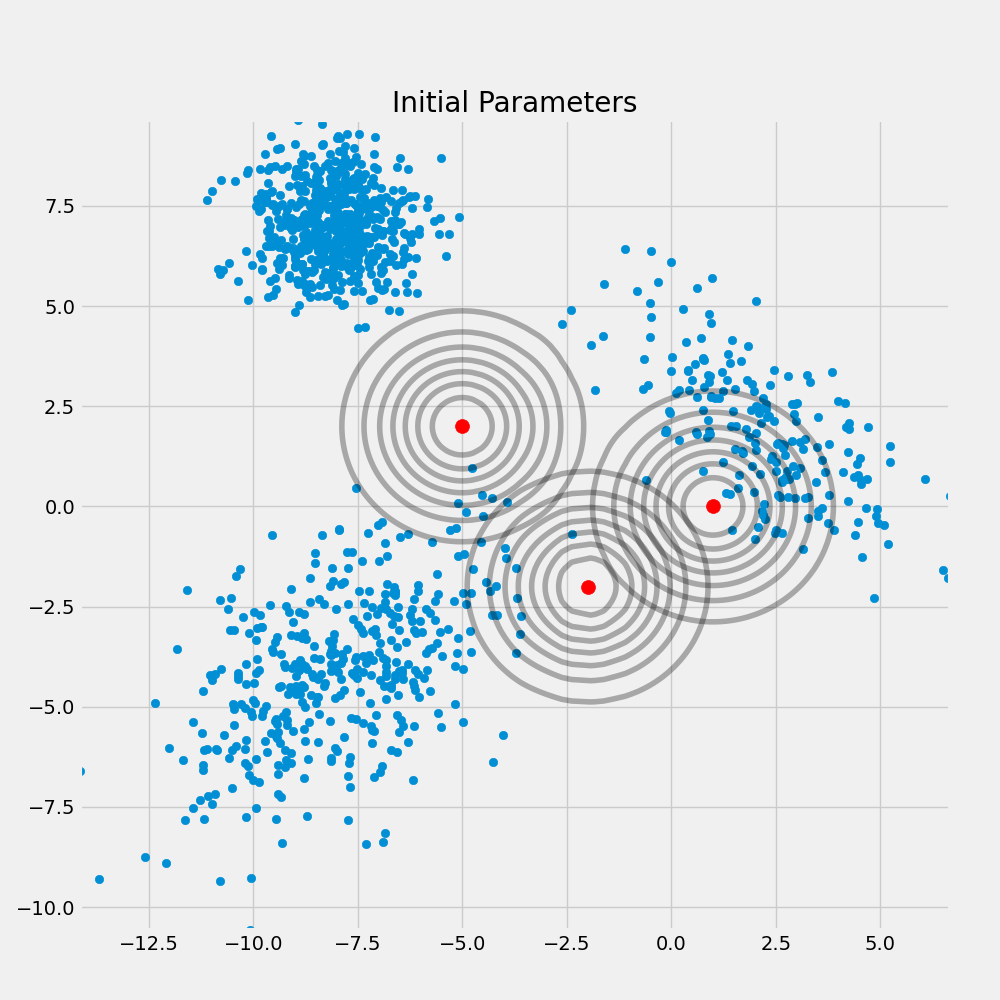

In [10]:
plot_results(X, mu=mu,cov=cov, title='Initial Parameters')
%matplot plt

### E Step starts here

In [11]:
reg_cov = 1e-6*np.identity(d)
log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                     # if we have converged

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

$$R_{i,j}^{t-1}=P(y_j=i|x_j,\theta^{t-1})=\frac{\exp\left\{-\frac{1}{2}(x_j-\mu_i^{t-1})^T(\Sigma_i^{t-1})^{-1}(x_j-\mu_i^{t-1})\right\}\pi_i^{t-1}}
{\sum_{i=1}^{K} \exp\left\{-\frac{1}{2}(x_j-\mu_i^{t-1})^T(\Sigma_i^{t-1})^{-1}(x_j-\mu_i^{t-1})\right\}\pi_i^{t-1}}$$

In [12]:
print(X.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1200, 2)

In [13]:
data=sc.parallelize(list(X))
data.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[array([-9.20247531,  7.41609963]), array([1.92297908, 1.00010831]), array([-8.36111313,  7.60896234]), array([-5.07090376,  7.22285832])]

In [14]:
def calc_temp_rij(p: np.ndarray, mu: np.ndarray, cov: np.ndarray, pi: np.ndarray):
    vec = np.zeros(K)
    for i in range(K):
        mu_i=mu[i,:]
        cov_i=cov[i,:,:]
        pi_i=pi[i]
        vec[i]= pi_i*multivariate_normal(mean=mu_i,cov=cov_i+reg_cov).pdf(np.array(p))
    return vec

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
temp_r_ij = data.map(lambda p: (calc_temp_rij(p, mu, cov, pi),p))
temp_r_ij.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(array([1.41518456e-19, 2.09538304e-07, 1.46184371e-17]), array([-9.20247531,  7.41609963])), (array([1.66947025e-02, 1.29254697e-07, 5.96369556e-05]), array([1.92297908, 1.00010831])), (array([4.20066884e-18, 6.04410726e-07, 1.01285974e-16]), array([-8.36111313,  7.60896234])), (array([5.72599960e-12, 2.89352548e-05, 1.46011590e-12]), array([-5.07090376,  7.22285832]))]

In [16]:
def norm_temp_rij(p):
    rij_val=p[0]/np.sum(p[0])
    print(rij_val)
    return (rij_val, p[1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
r_ij=temp_r_ij.map(norm_temp_rij)
r_ij.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(array([6.75382272e-13, 1.00000000e+00, 6.97649874e-11]), array([-9.20247531,  7.41609963])), (array([9.96432820e-01, 7.71464012e-06, 3.55946563e-03]), array([1.92297908, 1.00010831])), (array([6.95002365e-12, 1.00000000e+00, 1.67578055e-10]), array([-8.36111313,  7.60896234])), (array([1.97890021e-07, 9.99999752e-01, 5.04614716e-08]), array([-5.07090376,  7.22285832]))]

In [18]:
r_ij_sumj = r_ij.map(lambda a: a[0]).reduce(lambda a,b: a+b)
r_ij_sumj

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([189.0400862 , 749.45457768, 261.50533613])

In [19]:
np.sum(r_ij_sumj)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1199.9999999999998

In [20]:
def calc_wij(p,r_ij_sumj):
    vec = np.zeros(K)
    for i in range(K):
        vec[i]= p[0][i]/r_ij_sumj[i]
    return (vec, p[1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
w_ij = r_ij.map(lambda p: calc_wij(p,r_ij_sumj))
w_ij.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(array([3.57269342e-15, 1.33430368e-03, 2.66782271e-13]), array([-9.20247531,  7.41609963])), (array([5.27101336e-03, 1.02936727e-08, 1.36114455e-05]), array([1.92297908, 1.00010831])), (array([3.67648142e-14, 1.33430368e-03, 6.40820784e-13]), array([-8.36111313,  7.60896234])), (array([1.04681512e-09, 1.33430335e-03, 1.92965361e-10]), array([-5.07090376,  7.22285832]))]

### M-Step starts here

$$\mu_i^t=\sum_{j=1}^n w_{ij} x_j
\textrm{, where }  w_{ij} =\frac {P( y_j=i|x_j,\theta^{t-1})}{\sum_{l=1}^n P( y_l=i|x_l,\theta^{t-1})} = \frac{R_{ij}}{\sum_{l=1}^n R_{il}}
$$

$$\Sigma_i^t=\sum_{j=1}^n w_{ij}(x_j-\mu_i^t)^T(x_j-\mu_i^t)$$

$$\pi_i^t=\frac{1}{n}\sum_{j=1}^n R_{ij}$$

$$\mu_i^t=\sum_{j=1}^n w_{ij} x_j
\textrm{, where }  w_{ij} =\frac {P( y_j=i|x_j,\theta^{t-1})}{\sum_{l=1}^n P( y_l=i|x_l,\theta^{t-1})} = \frac{R_{ij}}{\sum_{l=1}^n R_{il}}
$$

In [22]:
"""M Step"""


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'M Step'

In [23]:
new_pi=r_ij_sumj/n_samples
print(new_pi)
print(np.sum(new_pi))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.15753341 0.62454548 0.21792111]
0.9999999999999998

In [24]:
w_ij.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(array([3.57269342e-15, 1.33430368e-03, 2.66782271e-13]), array([-9.20247531,  7.41609963])), (array([5.27101336e-03, 1.02936727e-08, 1.36114455e-05]), array([1.92297908, 1.00010831])), (array([3.67648142e-14, 1.33430368e-03, 6.40820784e-13]), array([-8.36111313,  7.60896234])), (array([1.04681512e-09, 1.33430335e-03, 1.92965361e-10]), array([-5.07090376,  7.22285832]))]

In [25]:
new_mu = np.zeros([K,d])
for i in range(K):
    new_mu[i,:]=w_ij.map(lambda a: a[0][i]*a[1]).reduce(lambda a,b : a+b)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
new_mu

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[ 2.31677332,  1.7374983 ],
       [-8.05863195,  5.15331018],
       [-7.65336193, -4.71705356]])

In [27]:
w_ij.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(array([3.57269342e-15, 1.33430368e-03, 2.66782271e-13]), array([-9.20247531,  7.41609963])), (array([5.27101336e-03, 1.02936727e-08, 1.36114455e-05]), array([1.92297908, 1.00010831])), (array([3.67648142e-14, 1.33430368e-03, 6.40820784e-13]), array([-8.36111313,  7.60896234])), (array([1.04681512e-09, 1.33430335e-03, 1.92965361e-10]), array([-5.07090376,  7.22285832]))]

In [28]:
new_cov = np.zeros([K,d,d])
for i in range(K):
    new_cov[i,:,:]=w_ij.map(lambda a: a[0][i]*np.outer(a[1]-new_mu[i],a[1]-new_mu[i])).reduce(lambda a,b : a+b)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
new_cov

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[[ 2.4984899 , -1.53385487],
        [-1.53385487,  2.46660871]],

       [[ 2.08619765,  1.03314813],
        [ 1.03314813, 15.97780823]],

       [[ 4.04102616,  2.45711407],
        [ 2.45711407,  3.18532661]]])

**DEBUG**

In [30]:
# Calculate for each datapoint x_j the probability r_ij that datapoint x_j belongs to cluster i
if 0:
    mu = mu0
    r_ij_np = np.zeros([K,n_samples])
    print(r_ij_np.shape)

    for j in range(n_samples):
        for i in range(K):
            mn = multivariate_normal(mean=mu[i,:],cov=cov[i,:,:]+reg_cov)
            r_ij_np[i,j]=pi[i]*mn.pdf(X[j,:])
        r_ij_np[:,j]=r_ij_np[:,j]/np.sum(r_ij_np[:,j])
        
    print(r_ij_np[:,0:5].T)
    print(np.sum(r_ij_np[:,:],axis=1))
    
    print(np.allclose(np.stack(r_ij.map(lambda a: a[0]).collect()), r_ij_np.T))
    
if 0:
    w_ij_np=np.zeros([K,n_samples])
    for i in range(K):
      for j in range(n_samples):
        w_ij_np[i,j] = r_ij_np[i,j]/np.sum(r_ij_np[i,:])

    print(w_ij_np[:,:4].T)
    print(np.allclose(np.stack(w_ij.map(lambda a: a[0]).collect()), w_ij_np.T))
    
if 0:
    mu_np =[]
    for i in range(K):
        # Updating the mean vectors mu_i:
        mu_i = np.zeros([1,d])
        for j in range(n_samples):
            mu_i=mu_i+w_ij_np[i,j]*X[j,:]
        mu_np.append(mu_i)
        
if 0:
    cov_np=[]
    for i in range(K):
        Sigma_i = np.zeros([d,d])
        for j in range(n_samples):
            Sigma_i = Sigma_i + w_ij_np[i,j]*np.dot((X[j,:]- mu_np[i]).T,  X[j,:]- mu_np[i])
        cov_np.append(Sigma_i)
    print(cov_np)

if 0:
    for i in range(K):
        # Calculate pi_new
        pi.append(1/n_samples*np.sum(r_ij[i,:])) 
    print(pi)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
new_pi

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.15753341, 0.62454548, 0.21792111])

In [32]:
new_mu

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[ 2.31677332,  1.7374983 ],
       [-8.05863195,  5.15331018],
       [-7.65336193, -4.71705356]])

In [33]:
new_cov

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[[ 2.4984899 , -1.53385487],
        [-1.53385487,  2.46660871]],

       [[ 2.08619765,  1.03314813],
        [ 1.03314813, 15.97780823]],

       [[ 4.04102616,  2.45711407],
        [ 2.45711407,  3.18532661]]])

In [34]:
if 0:
    mu=np.squeeze(np.array(mu))
    print(mu)

    """Log likelihood"""
    log_likelihoods.append(np.log(np.sum([k*multivariate_normal(mu[i],cov[j]).pdf(X) for k,i,j in zip(pi,range(len(mu)),range(len(cov)))])))

    print(log_likelihoods)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

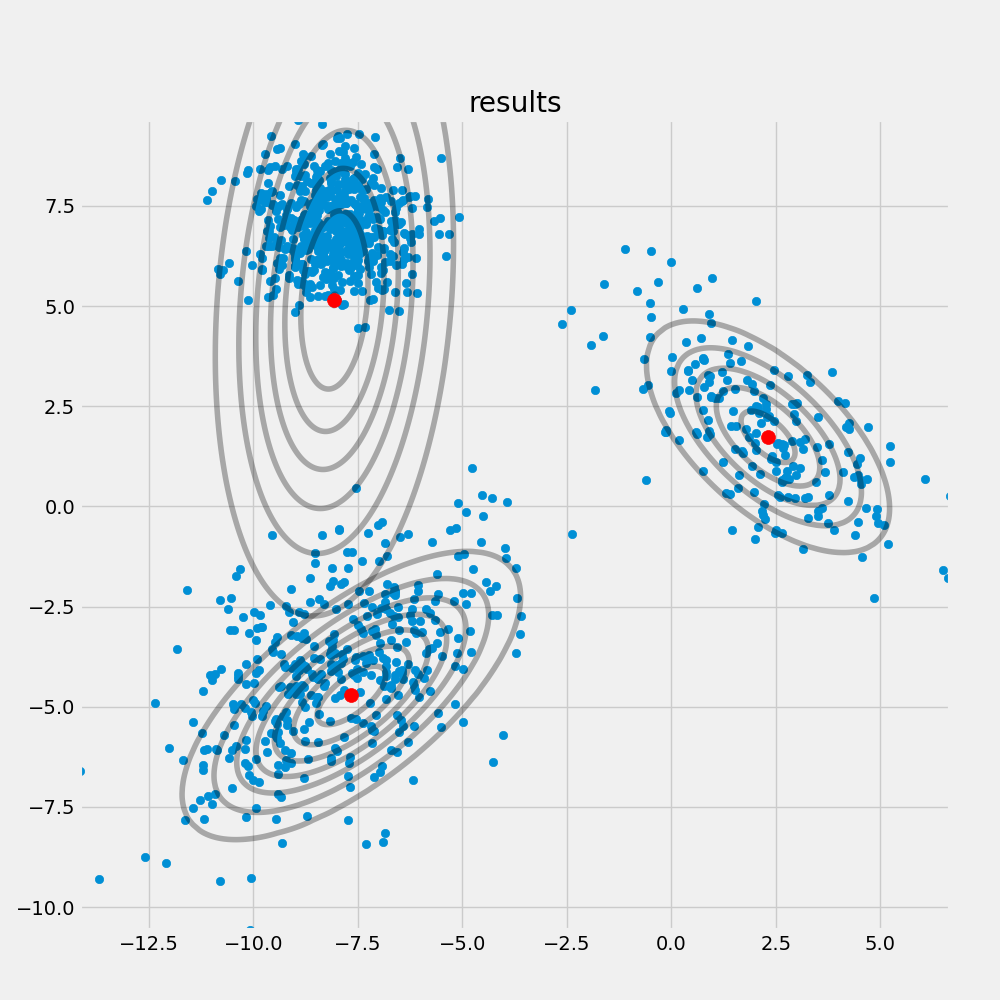

In [35]:
plot_results(X, mu=new_mu,cov=new_cov)
%matplot plt

In [36]:
print("Now go back to the E Step!")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now go back to the E Step!

### Putting everything together

In [37]:
class GMM:
    def __init__(self,data,number_of_sources,iterations):
        self.iterations = iterations
        self.K = number_of_sources
        self.dim = 2
        self.data = data
        self.mu = None
        self.pi = None
        self.cov = None
        
    
    """Define a function which runs for self.iterations iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(X[0,:]))
           
        n_samples= data.count()
        K= self.K

        """ 1. Set the initial mu, covariance and pi values"""
        np.random.seed(0)
        self.mu, self.cov, self.pi = init_params(self.K,self.dim)
        
         
        #plot_results(X,mu=self.mu,cov=self.cov)
        
        for iter in range(self.iterations):  
            print('iter:', iter)
            """E Step"""

            mu = self.mu
            cov = self.cov
            pi = self.pi

            temp_r_ij = data.map(lambda p: (calc_temp_rij(p, mu, cov, pi),p))
            r_ij=temp_r_ij.map(norm_temp_rij)
            r_ij_sumj = r_ij.map(lambda a: a[0]).reduce(lambda a,b: a+b)
            w_ij = r_ij.map(lambda p: calc_wij(p,r_ij_sumj))

            """M Step"""
            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            
            
            new_pi=r_ij_sumj/n_samples

            new_mu = np.zeros([K,d])
            for i in range(K):
                new_mu[i,:]=w_ij.map(lambda a: a[0][i]*a[1]).reduce(lambda a,b : a+b)

            new_cov = np.zeros([K,d,d])
            for i in range(K):
                new_cov[i,:,:]=w_ij.map(lambda a: a[0][i]*np.outer(a[1]-new_mu[i],a[1]-new_mu[i])).reduce(lambda a,b : a+b)

            
            self.mu = new_mu
            self.cov = new_cov
            self.pi = new_pi
            
            print('mu:', np.array(self.mu))
            print('cov:', np.array(self.cov))
            print('pi:', self.pi)
            
            #plot_results(X,mu=self.mu,cov=self.cov, title=f'results_{iter+1}')
               
    
    


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
data=sc.parallelize(list(X))
data.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[array([-9.20247531,  7.41609963]), array([1.92297908, 1.00010831]), array([-8.36111313,  7.60896234]), array([-5.07090376,  7.22285832])]

In [39]:
GMM = GMM(data,number_of_sources=3,iterations=8)     
GMM.run()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]
iter: 0
mu: [[ 2.31677331  1.73749831]
 [-8.05863197  5.15331029]
 [-7.65336197 -4.71705363]]
cov: [[[ 2.49848986 -1.53385488]
  [-1.53385488  2.4666087 ]]

 [[ 2.08619756  1.0331482 ]
  [ 1.0331482  15.97780718]]

 [[ 4.04102568  2.4571138 ]
  [ 2.4571138   3.18532623]]]
pi: [0.15753341 0.62454547 0.21792112]
iter: 1
mu: [[ 2.12943452  1.89532631]
 [-8.10406326  5.85958457]
 [-7.85846215 -4.48655415]]
cov: [[[ 3.0369317  -1.99544337]
  [-1.99544337  2.85997644]]

 [[ 1.21068326  0.48037695]
  [ 0.48037695 10.8957519 ]]

 [[ 4.11804652  2.2545496 ]
  [ 2.2545496   3.14859392]]]
pi: [0.16644203 0.56915785 0.26440012]
iter: 2
mu: [[ 2.12544009  1.89735036]
 [-8.07758276  6.610576  ]
 [-7.94157678 -4.27352014]]
cov: [[[ 3.05280482 -2.00383279]
  [-2.00383279  2.86410787]]

 [[ 1.02519154  0.13211402]
  [ 0.13211402  4.37015799]]

 [[ 4.02291985  

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

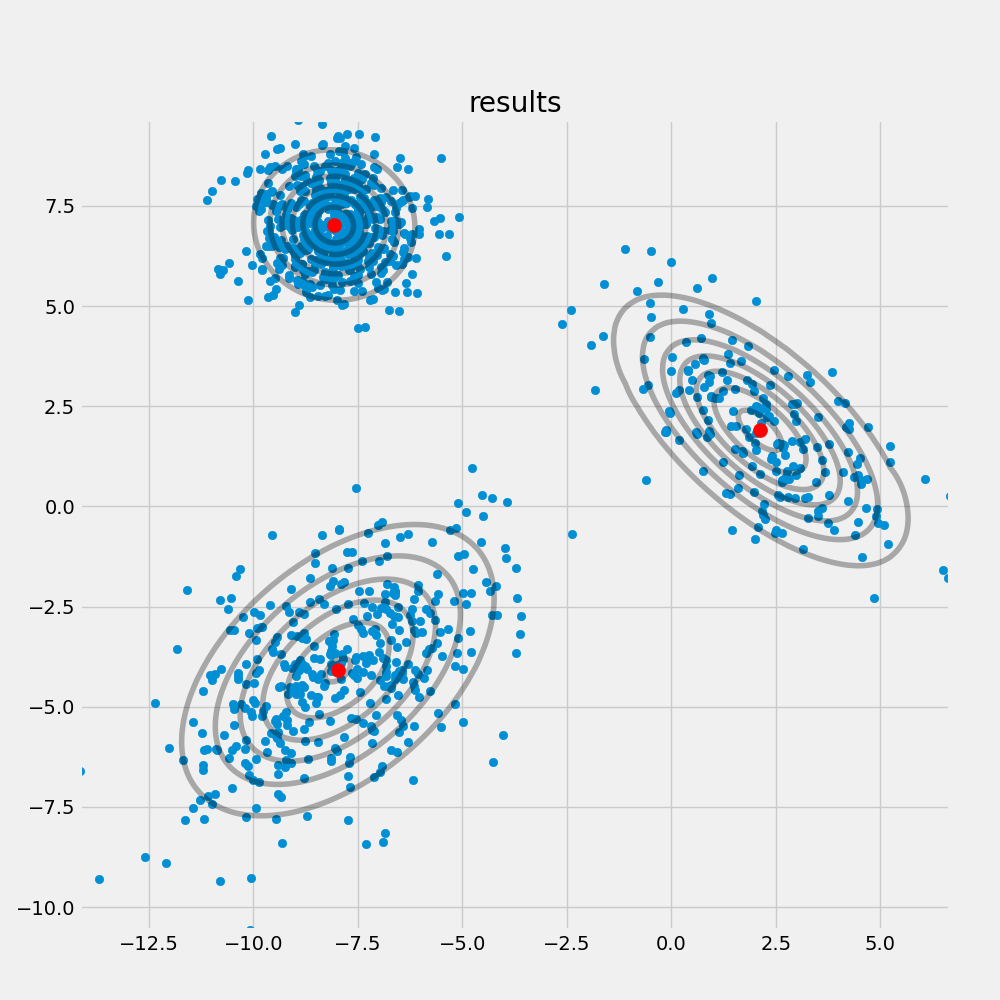

In [40]:
mu=GMM.mu
cov = GMM.cov
pi = GMM.pi

plot_results(X, mu=mu,cov=cov)
%matplot plt